In [190]:
import math, os, sys, random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from functools import partial
from IPython.display import Image
%matplotlib inline

1.36096404744


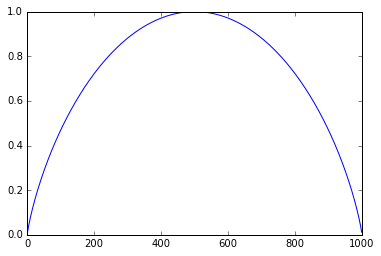

In [66]:
# ENTROPY
#  H = - p1*log(p1) - ... - pk*log(pk)
#  the idea of Decision Tree is that at each branching, we find the split that
#   maximized the reduction in entropy: i.e. maximizing the uncertainty in classification.
def entropy(*classProbs):
    # NB: log base = 2.
    if sum(classProbs) != 1: return 'INPUT IS NOT A PROBABILITY DISTRIBUTION!'
    else:
        return -sum(classProb*math.log(classProb,2) for classProb in classProbs if classProb) # ignore 0.
print entropy(*[.5,.1,.4])
plt.plot([entropy(p, 1-p) for p in np.arange(0,1,.001)])

In [67]:
# CLASS PROBABILITIES & DATA ENTROPY
def class_probabilities(labels):
    totalCount = len(labels)
    return [float(count)/totalCount for count in Counter(labels).values()]
def data_entropy(labeledData):
    # labeledDate: [data_i, label_i, ...].
    labels = [label for _, label in labeledData]
    probabilities = class_probabilities(labels)
    return entropy(*probabilities)

In [68]:
# DEMO: IRIS
from sklearn.datasets import load_iris
X, y = load_iris()['data'], load_iris()['target']
data_entropy(zip(X,y))

1.584962500721156

In [69]:
# PARTITION ENTROPY: SUM OF ENTROPIES OF CHILDREN
#  H = q1*H(S1) + ... + qm*H(Sm)
#   qi: proportion of ith subset; H(Si): entropy of ith subset.
def partition_entropy(subsets):
    totalCount = sum(len(subset) for subset in subsets)
    return sum(data_entropy(subset) * len(subset)/totalCount for subset in subsets)

### STEP-BY-STEP WALKTHROUGH OF ID3

In [167]:
# CREATING DT: DATA
#  data: interview well True/False.
inputs = [ # (dict, label) tuples.
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'no'}, False),
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'yes'}, False),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'yes'}, False),
    ({'level':'Mid', 'lang':'R', 'tweets':'yes', 'phd':'yes'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'no', 'phd':'no'}, False),
    ({'level':'Senior', 'lang':'R', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'yes', 'phd':'yes'}, True),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, True),
    ({'level':'Mid', 'lang':'Java', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, False)
]

### ID3 ALGORITHM
* If the data all have the SAME LABEL, then create a leaf node that predicts that label and then stop.
* If the list of ATTRIBUTES IS EMPTY, then create a leaf node that predicts the most common label and then stop.
* Otherwise, try partitioning the data by each of the attributes.
    * Choose the partition with the LOWEST PARTITION ENTROPY.
    * ADD A DECISION NODE based on the chosen attribute.
* Recur on each partitioned subset using the remaining attributes.

In [168]:
def partition_by(inputs, attribute):
    # each input is a pair (attribute_dict, label).
    # returns a dict: attribute_value -> inputs.
    groups = defaultdict(list)
    for input in inputs:
        key = input[0][attribute] # get the val of attribute (input[0] is an attribute dict).
        groups[key].append(input) # add input to correct list.
    return groups
eg = ''' 
partition_by(inputs, 'level')['Junior']
[({'lang': 'Python', 'level': 'Junior', 'phd': 'no', 'tweets': 'no'}, True),
 ({'lang': 'R', 'level': 'Junior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'R', 'level': 'Junior', 'phd': 'yes', 'tweets': 'yes'}, False),
 ({'lang': 'Python', 'level': 'Junior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Junior', 'phd': 'yes', 'tweets': 'no'}, False)]
'''
def partition_entropy_by(inputs, attribute):
    # compute entropy of partition.
    partitions = partition_by(inputs, attribute)
    return partition_entropy(partitions.values())
eg = '''
partition_by(inputs, 'level').values()[0]
[({'lang': 'Java', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}, False),
 ({'lang': 'Java', 'level': 'Senior', 'phd': 'yes', 'tweets': 'no'}, False),
 ({'lang': 'Python', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}, False),
 ({'lang': 'R', 'level': 'Senior', 'phd': 'no', 'tweets': 'yes'}, True),
 ({'lang': 'Python', 'level': 'Senior', 'phd': 'yes', 'tweets': 'yes'}, True)]
 
data_entropy() then works on the output in partition_entropy(), which computes 
  the entropy for the probabilities of the label (i.e. T/F): [False: 3/5; True: 2/5].
'''

In [169]:
# TO FIND THE ATTRIBUTE WITH THE MINIMAL SPLIT ENTROPY...
for key in ['level','lang','tweets','phd']:
    print key, partition_entropy_by(inputs, key)

level 0.693536138896
lang 0.860131712855
tweets 0.788450457308
phd 0.892158928262


In [170]:
# LOOKS LIKE 'level' PRODUCES THE LOWEST ENTROPY...
# LET'S OBSERVE THE LABELS UNDER EACH VALUE OF 'level' then.
levelSplit = partition_by(inputs, 'level')
print 'Labels in Junior: ', [label for _, label in levelSplit['Junior']]
print 'Labels in Mid: ', [label for _, label in levelSplit['Mid']]
print 'Labels in Senior: ', [label for _, label in levelSplit['Senior']]

Labels in Junior:  [True, True, False, True, False]
Labels in Mid:  [True, True, True, True]
Labels in Senior:  [False, False, False, True, True]


In [171]:
# 'Junior' AND 'Senior' NEED FURTHER PARTITION, WHEREAS 'Mid' IS A PURE SET (SIMPLY PREDICT True).
# TAKE 'Senior' FOR INSTANCE:
seniorInputs = [(input, label) for input,label in inputs if input['level']=='Senior']
# NOW FIND OUT WHICH FURTHER NODE A SPLIT PRODUCES THE LOWEST ENTROPY...
for key in ['lang','tweets','phd']:
    print key, partition_entropy_by(seniorInputs, key)

lang 0.4
tweets 0.0
phd 0.950977500433


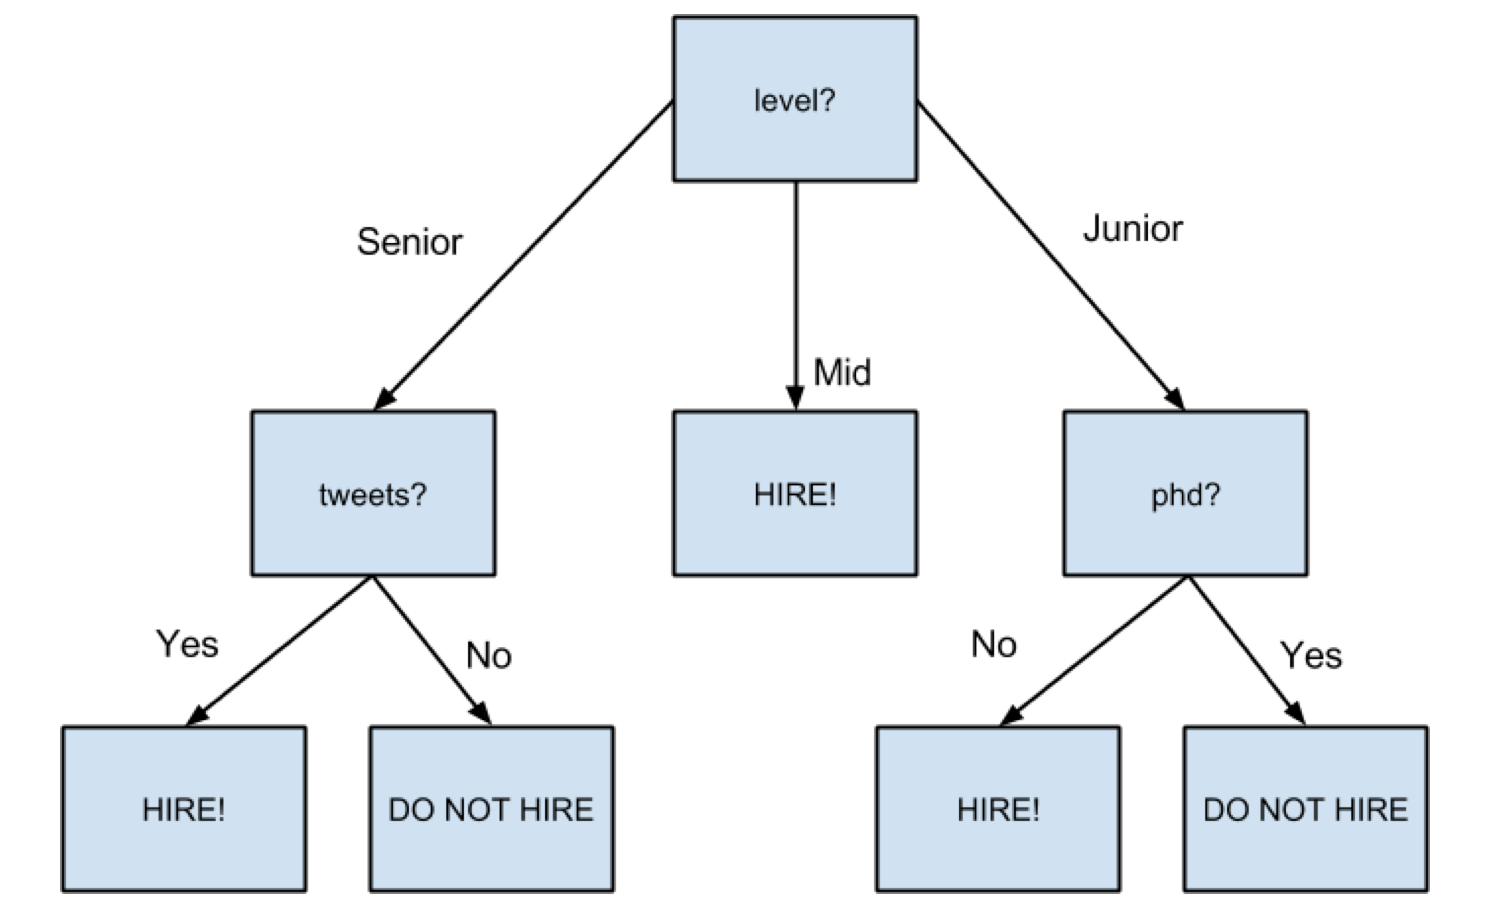

In [172]:
# NEXT SPLIT WILL BE ON 'tweets'...
# SO ON AND SO FORTH, WE GET THE FOLLOWING DT:
Image(filename='/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DATA_SCIENCE/DATA/decision_tree.png', 
      width="40%")

In [173]:
# THE DICT REPRESENTATION OF THE TREE...
dict = ('level',
        {'Junior': ('phd', {'no': True, 'yes': False}),
         'Mid': True,
         'Senior': ('tweets', {'no': False, 'yes': True})})
    # NB: In the case where an attribute comes with a new value in new input, 
    #  we add a None key for it and predict the most common label.

### DT IMPLEMENTATION

In [183]:
# CLASSIFY FUNCTION
def classify(tree, new):
    # classify the input using the given decision tree.
    #  new: to-be-classified: e.g. { "level" : "Junior", "lang" : "Java", "tweets" : "yes", "phd" : "no"}.
    if tree in [True, False]: return tree # Pure node. e.g. 'Mid': True, return True.
    attribute, subtreeDict = tree 
        # e.g. 'Junior': ('phd', {'no': True, 'yes': False}).
        #  where attribute='phd', subtreeDict={'no': True, 'yes': False}.
    subtreeKey = new.get(attribute)
    if subtreeKey not in subtreeDict: subtreeKey = None
    subtree = subtreeDict[subtreeKey] # assuming subtreeDict is a defaultdict(list) or something.
    return classify(subtree, new)

In [184]:
# ID3 FUNCTION: BUILD TREE FROM INPUTS
def build_tree_id3(inputs, splitCandidate=None):
    if splitCandidate is None:
        splitCandidate = inputs[0][0].keys()
        # if this is 1st pass, all keys are split candidates.
        #  e.g. inputs[0][0]={'lang': 'Java', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}.
    numInputs = len(inputs)
    numTrues = len([label for item,label in inputs if label]) # item is a dict, label is a T/F value.
    numFalses = numInputs - numTrues
    if numTrues==0: return False
    if numFalses==0: return True
    if not splitCandidate: # if no split candidates left.
        return numTrues >= numFalses # return majority leaf.
    bestAttr = min(splitCandidate, key=partial(partition_entropy_by, inputs)) # partial unfed: attribute.
    partitions = partition_by(inputs, bestAttr)
    newCandidate = [a for a in splitCandidate if a != bestAttr] # bestAttr used, eliminate from future candidates.
    subtrees = {attributeVal: build_tree_id3(subset, newCandidate) for attributeVal,subset in partitions.iteritems()}
    subtrees[None] = numTrues > numFalses # default case.
    return (bestAttr, subtrees)

In [185]:
# DID THE NEWGUY INTERVIEW WELL?
newGuy = { 'level' : 'Junior', 'lang' : 'Java', 'tweets' : 'yes', 'phd' : 'no'}
tree = build_tree_id3(inputs)
classify(tree, newGuy)

True

### RANDOM FOREST

In [210]:
# VOTING 
#  Idea: avoid DT's tendency to overfitting by building multiple
#   DTs and let them vote on how to classify inputs.
#  NB: we need trees to be RANDOMLY generated, which calls for need to revise the current tree building process.
def forest_classify(trees, new):
    votes = [classify(tree, new) for tree in trees]
    voteCounts = Counter(votes)
    print 'Voting Results: ', voteCounts
    return voteCounts.most_common(1)[0][0] # voteCounts.most_common(1) format: [(True, 9)].

In [216]:
# DEMO 2 APPROACES ON DATA
inputs = [ # (dict, label) tuples.
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'no'}, False),
    ({'level':'Senior', 'lang':'Java', 'tweets':'no', 'phd':'yes'}, False),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'R', 'tweets':'yes', 'phd':'yes'}, False),
    ({'level':'Mid', 'lang':'R', 'tweets':'yes', 'phd':'yes'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'no', 'phd':'no'}, False),
    ({'level':'Senior', 'lang':'R', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Senior', 'lang':'Python', 'tweets':'yes', 'phd':'yes'}, True),
    ({'level':'Mid', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, True),
    ({'level':'Mid', 'lang':'Java', 'tweets':'yes', 'phd':'no'}, True),
    ({'level':'Junior', 'lang':'Python', 'tweets':'no', 'phd':'yes'}, False)
]

### FOREST GENERATION I: BAGGING

In [217]:
# BOOTSTRAP SAMPLE DATA SETS
def bootstrap_sample(data):
    # randomly sample len(data) elements w/ replacement.
    # NB: works with both pd.DataFrame and np.ndarray.
    return [random.choice(data) for _ in data]

In [218]:
# RANDOMLY GENERATE 10 TREES
trees = [build_tree_id3(bootstrap_sample(inputs)) for _ in range(10)]

In [219]:
# VOTING ON CLASSIFICATION OF NEWGUY
newGuy = { 'level' : 'Junior', 'lang' : 'Java', 'tweets' : 'yes', 'phd' : 'no'}
forest_classify(trees, newGuy)

Voting Results:  Counter({True: 8, False: 2})


True

### FOREST GENERATION II: RANDOM ATTRIBUTES SUBSETTING

In [247]:
def build_tree_id3_rand(inputs, subsetSize=.5, splitCandidate=None): # 50% as the subset size.
    if splitCandidate is None:
        splitCandidate = inputs[0][0].keys()
        # if this is 1st pass, all keys are split candidates.
        #  e.g. inputs[0][0]={'lang': 'Java', 'level': 'Senior', 'phd': 'no', 'tweets': 'no'}.
    numInputs = len(inputs)
    numTrues = len([label for item,label in inputs if label]) # item is a dict, label is a T/F value.
    numFalses = numInputs - numTrues
    if numTrues==0: return False
    if numFalses==0: return True
    if not splitCandidate: # if no split candidates left.
        return numTrues >= numFalses # return majority leaf.
    # SUBSETTING STEP: 
    #  ORIGINAL: bestAttr = min(splitCandidate, key=partial(partition_entropy_by, inputs)) # partial unfed: attribute.
    subsetCandidates = [random.choice(splitCandidate) for _ in range(int(len(splitCandidate)*subsetSize))]
    bestSubAttr = min(subsetCandidates, key=partial(partition_entropy_by, inputs))
    # print 'CURRENT SUBSET: ', subsetCandidates # IF NEED TO CHECK WORKING CORRECTLY.
    partitions = partition_by(inputs, bestSubAttr)
    newCandidate = [a for a in splitCandidate if a != bestSubAttr] # bestAttr used, eliminate from future candidates.
    subtrees = {attributeVal: build_tree_id3(subset, newCandidate) for attributeVal,subset in partitions.iteritems()}
    subtrees[None] = numTrues > numFalses # default case.
    return (bestSubAttr, subtrees)

In [248]:
# DID THE NEWGUY INTERVIEW WELL?
newGuy = { 'level' : 'Junior', 'lang' : 'Java', 'tweets' : 'yes', 'phd' : 'no'}
trees = [build_tree_id3_rand(inputs) for _ in range(10)]
Counter([classify(tree, newGuy) for tree in trees]).most_common(1)[0][0]

True